# Beach Crowd Prediction — LSTM, TFT, TiDE + Optuna Optimization

This notebook compares models across **three dataset strategies**:
1. **Daytime only** — remove night hours (6PM–6AM)
2. **Full 24h** — keep all data including noisy night counts
3. **Night = 0** — keep 24h but replace night counts with 0

Models tested:
- **Sklearn baselines**: Lasso, RandomForest, XGBoost, LightGBM, CatBoost
- **NeuralForecast**: LSTM, TFT, TiDE
- **Optuna-optimized**: XGBoost, LightGBM, CatBoost, LSTM

In [1]:
# === PATHS ===
CACHE_DIR = "cache/predictions"
COUNTING_MODEL = "bayesian_vgg19"
SAVE_DIR = "models/tft_chunks"

# === SAMPLING ===
SAMPLE_FRAC = 1.0
MAX_BEACHES = None

# === TFT PARAMETERS ===
MAX_STEPS = 500
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
INPUT_SIZE = 48
HORIZON = 168  # 1 week = 7 days

# === TIME ===
NIGHT_START = 20
NIGHT_END = 6

# === FLAGS ===
RUN_SKLEARN = False
RUN_NEURALFORECAST = True
RUN_OPTUNA = False

In [2]:
import subprocess, sys
for pkg in ["neuralforecast", "utilsforecast"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

In [3]:
import json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE

HAS_NF = True

if torch.cuda.is_available():
    ACCELERATOR = 'gpu'
    DEVICES = 1
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    ACCELERATOR = 'mps'
    DEVICES = 1
else:
    ACCELERATOR = 'cpu'
    DEVICES = 1

print(f"Device: {ACCELERATOR} | PyTorch: {torch.__version__}")

Device: mps | PyTorch: 2.9.1


In [4]:
def calc_metrics(y_true, y_pred, max_count):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rel_mae = (mae / max_count) * 100 if max_count > 0 else 0
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'RelMAE': rel_mae}

def eval_per_beach(df, y_pred, beach_col='unique_id'):
    results = []
    for b in df[beach_col].unique():
        mask = df[beach_col] == b
        if mask.sum() < 3:
            continue
        y_true = df.loc[mask, 'y'].values if 'y' in df.columns else df.loc[mask, 'count'].values
        y_p = y_pred[mask.values] if hasattr(mask, 'values') else y_pred[mask]
        max_count = y_true.max()
        m = calc_metrics(y_true, y_p, max_count)
        m['camera'] = b
        m['max_count'] = max_count
        m['n'] = mask.sum()
        results.append(m)
    return pd.DataFrame(results)

## Load and Prepare Data

In [5]:
def load_cache(cache_dir, model):
    cache_path = Path(cache_dir) / model
    records = []
    for jf in cache_path.rglob("*.json"):
        try:
            with open(jf) as f:
                r = json.load(f)
            if 'error' not in r:
                records.append(r)
        except: pass
    
    rows = []
    for r in records:
        row = {
            'beach': r.get('beach') or r.get('beach_folder'),
            'beach_folder': r.get('beach_folder'),
            'datetime': r.get('datetime'),
            'count': r.get('count')
        }
        for k, v in r.get('weather', {}).items():
            row[k] = v
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

df_raw = load_cache(CACHE_DIR, COUNTING_MODEL)
print(f"Loaded: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Loaded: 169241 rows, 41 beaches


In [6]:
EXCLUDE = ['livecampro/001', 'livecampro/011', 'livecampro/018', 'livecampro/021',
    'livecampro/030', 'livecampro/039', 'livecampro/070', 'MultimediaTres/PortAndratx',
    'SeeTheWorld/mallorca_pancam', 'skyline/es-pujols']
EXCLUDE_PREFIX = ['ibred', 'ClubNauticSoller', 'Guenthoer', 'youtube']

before = len(df_raw)
df_raw = df_raw[~df_raw['beach_folder'].isin(EXCLUDE)]
for p in EXCLUDE_PREFIX:
    df_raw = df_raw[~df_raw['beach_folder'].str.startswith(p, na=False)]
print(f"Filtered: {before} -> {len(df_raw)}")

Filtered: 169241 -> 70501


In [7]:
if SAMPLE_FRAC < 1.0:
    df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=42).sort_values('datetime').reset_index(drop=True)

if MAX_BEACHES:
    top = df_raw['beach'].value_counts().head(MAX_BEACHES).index.tolist()
    df_raw = df_raw[df_raw['beach'].isin(top)].reset_index(drop=True)

print(f"Final: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Final: 70501 rows, 14 beaches


In [8]:
df = df_raw.copy()
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_night'] = ((df['hour'] >= NIGHT_START) | (df['hour'] <= NIGHT_END)).astype(int)

WEATHER_COLS = [c for c in df.columns if c.startswith('ae_') or c.startswith('om_')]
TEMPORAL_COLS = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer', 'is_night']
ALL_FEATURES = WEATHER_COLS + TEMPORAL_COLS

df = df.dropna(subset=ALL_FEATURES + ['count']).reset_index(drop=True)
good = df.groupby('beach')['count'].max()
good = good[good > 20].index.tolist()
df = df[df['beach'].isin(good)].reset_index(drop=True)

print(f"After cleaning: {len(df)} rows, {len(good)} beaches")
print(f"Features: {len(ALL_FEATURES)}")

After cleaning: 70090 rows, 14 beaches
Features: 35


## Create Three Dataset Strategies

In [9]:
ds_daytime = df[df['is_night'] == 0].copy().reset_index(drop=True)
ds_full24h = df.copy()
ds_night0 = df.copy()
ds_night0.loc[ds_night0['is_night'] == 1, 'count'] = 0.0

ds_nightq1 = df.copy()
q1_per_beach = ds_nightq1[ds_nightq1['is_night'] == 0].groupby('beach')['count'].quantile(0.25)
ds_nightq1.loc[ds_nightq1['is_night'] == 1, 'count'] = ds_nightq1.loc[ds_nightq1['is_night'] == 1, 'beach'].map(q1_per_beach).fillna(0)

ds_nightmin = df.copy()
min_per_beach = ds_nightmin[ds_nightmin['is_night'] == 0].groupby('beach')['count'].min()
ds_nightmin.loc[ds_nightmin['is_night'] == 1, 'count'] = ds_nightmin.loc[ds_nightmin['is_night'] == 1, 'beach'].map(min_per_beach).fillna(0)

datasets = {'Daytime': ds_daytime, 'Full24h': ds_full24h, 'Night0': ds_night0, 'NightQ1': ds_nightq1, 'NightMin': ds_nightmin}

print("=" * 80)
print("DATASET COMPARISON")
print("=" * 80)

for name, d in datasets.items():
    night_rows = d[d['is_night'] == 1] if 'is_night' in d.columns else pd.DataFrame()
    day_rows = d[d['is_night'] == 0] if 'is_night' in d.columns else d
    
    print(f"\n{name}:")
    print(f"  Total rows:     {len(d)}")
    print(f"  Beaches:        {d['beach'].nunique()}")
    print(f"  Night rows:     {len(night_rows)} ({len(night_rows)/len(d)*100:.1f}%)")
    print(f"  Day rows:       {len(day_rows)} ({len(day_rows)/len(d)*100:.1f}%)")
    print(f"  Count mean:     {d['count'].mean():.1f}")
    print(f"  Count max:      {d['count'].max():.1f}")
    print(f"  Zeros:          {(d['count'] == 0).sum()} ({(d['count'] == 0).sum()/len(d)*100:.1f}%)")

DATASET COMPARISON

Daytime:
  Total rows:     37643
  Beaches:        14
  Night rows:     0 (0.0%)
  Day rows:       37643 (100.0%)
  Count mean:     57.2
  Count max:      538.0
  Zeros:          0 (0.0%)

Full24h:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     53.8
  Count max:      538.0
  Zeros:          0 (0.0%)

Night0:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     30.7
  Count max:      538.0
  Zeros:          32447 (46.3%)

NightQ1:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     50.1
  Count max:      538.0
  Zeros:          0 (0.0%)

NightMin:
  Total rows:     70090
  Beaches:        14
  Night rows:     32447 (46.3%)
  Day rows:       37643 (53.7%)
  Count mean:     42.0
  Count max:      538.0
  Zeros:          0 (0.0%)


In [10]:
from utilsforecast.preprocessing import fill_gaps

def to_nf_format(df, id_col='beach_folder'):
    cols = ['datetime', id_col, 'count'] + ALL_FEATURES
    cols = [c for c in cols if c in df.columns]
    nf_df = df[cols].copy()
    nf_df = nf_df.rename(columns={'datetime': 'ds', id_col: 'unique_id', 'count': 'y'})
    return nf_df

def prepare_nf_data(df, freq='h'):
    nf = to_nf_format(df)
    nf = nf.groupby(['unique_id', 'ds']).mean(numeric_only=True).reset_index()
    nf = fill_gaps(nf, freq=freq)
    for col in nf.select_dtypes(include=[np.number]).columns:
        nf[col] = nf.groupby('unique_id')[col].transform(
            lambda x: x.interpolate(method='linear').ffill().bfill()
        )
    return nf

def create_temporal_chunks(df, n_chunks=6):
    date_min = df['datetime'].min()
    date_max = df['datetime'].max()
    total_days = (date_max - date_min).days
    chunk_days = total_days // n_chunks

    boundaries = []
    for i in range(n_chunks + 1):
        boundaries.append(date_min + pd.Timedelta(days=i * chunk_days))
    boundaries[-1] = date_max + pd.Timedelta(hours=1)

    chunks = []
    for i in range(n_chunks):
        mask = (df['datetime'] >= boundaries[i]) & (df['datetime'] < boundaries[i+1])
        chunk = df[mask].copy()
        chunks.append({
            'data': chunk,
            'start': boundaries[i],
            'end': boundaries[i+1] - pd.Timedelta(hours=1),
            'label': f"C{i+1}: {boundaries[i].strftime('%b %d')}→{(boundaries[i+1]-pd.Timedelta(hours=1)).strftime('%b %d')}"
        })
    return chunks, boundaries

N_CHUNKS = 6

date_min = df['datetime'].min()
date_max = df['datetime'].max()
total_days = (date_max - date_min).days

print("=" * 70)
print(f"TEMPORAL CHUNKING: {total_days} days → {N_CHUNKS} chunks of ~{total_days//N_CHUNKS} days")
print(f"Date range: {date_min.date()} to {date_max.date()}")
print("=" * 70)

all_chunks = {}
for ds_name in datasets.keys():
    chunks, boundaries = create_temporal_chunks(datasets[ds_name], N_CHUNKS)
    all_chunks[ds_name] = chunks
    print(f"\n{ds_name}:")
    for c in chunks:
        print(f"  {c['label']} | {len(c['data'])} rows")

# --- SIMPLE SLIDING: train=2 chunks, val=1, test=1 ---
print("\n" + "=" * 70)
print("SIMPLE SLIDING WINDOW (train=2 chunks, val=1, test=1)")
print("=" * 70)

simple_windows_all = {}
for ds_name in datasets.keys():
    chunks = all_chunks[ds_name]
    windows = []
    for i in range(len(chunks) - 3):
        train_data = pd.concat([chunks[i]['data'], chunks[i+1]['data']])
        windows.append({
            'name': f"SW{i+1}",
            'train_chunks': [chunks[i], chunks[i+1]],
            'train_data': train_data,
            'val_data': chunks[i+2]['data'],
            'test_data': chunks[i+3]['data'],
            'train_label': f"{chunks[i]['label'].split(':')[0]}+{chunks[i+1]['label'].split(':')[0]} (2 chunks)",
            'val_label': chunks[i+2]['label'],
            'test_label': chunks[i+3]['label'],
        })
    simple_windows_all[ds_name] = windows

    print(f"\n{ds_name}:")
    for w in windows:
        print(f"  {w['name']}: Train={w['train_label']} ({len(w['train_data'])} rows) | "
              f"Val={w['val_label']} | Test={w['test_label']}")

# --- ROLLING WINDOWS: train=expanding, val=1, test=1 ---
print("\n" + "=" * 70)
print("ROLLING WINDOW EXPERIMENTS (train=expanding, val=1 chunk, test=1 chunk)")
print("=" * 70)

rolling_windows = {}
for ds_name in datasets.keys():
    chunks = all_chunks[ds_name]
    windows = []
    for test_idx in range(2, N_CHUNKS):
        val_idx = test_idx - 1
        train_chunks = chunks[:val_idx]
        windows.append({
            'name': f"W{len(windows)+1}",
            'train_chunks': train_chunks,
            'train_data': pd.concat([c['data'] for c in train_chunks]),
            'val_data': chunks[val_idx]['data'],
            'test_data': chunks[test_idx]['data'],
            'train_label': f"{train_chunks[0]['label'].split(':')[0]}→{train_chunks[-1]['label'].split(':')[0]} ({len(train_chunks)} chunks)",
            'val_label': chunks[val_idx]['label'],
            'test_label': chunks[test_idx]['label'],
        })
    rolling_windows[ds_name] = windows

    print(f"\n{ds_name}:")
    for w in windows:
        print(f"  {w['name']}: Train={w['train_label']} ({len(w['train_data'])} rows) | "
              f"Val={w['val_label']} | Test={w['test_label']}")

# --- SPLIT-GAP: first 40% + last 40%, skip middle 20% ---
# Simulates having 2022 data + 2025 data with years missing in between
# Tests: does a model trained on disconnected periods generalize?
print("\n" + "=" * 70)
print("SPLIT-GAP EXPERIMENT (40% early | 20% gap | 40% late)")
print("Simulates: 2022 data + 2025 data, no data in between")
print("=" * 70)

split_gap_windows = {}
for ds_name in datasets.keys():
    ds = datasets[ds_name].sort_values('datetime').reset_index(drop=True)
    n = len(ds)

    early = ds.iloc[:int(n * 0.4)]
    late = ds.iloc[int(n * 0.6):]
    gap_start = ds.iloc[int(n * 0.4)]['datetime']
    gap_end = ds.iloc[int(n * 0.6)]['datetime']

    def split_period(period_df, period_name):
        np_ = len(period_df)
        tr = period_df.iloc[:int(np_ * 0.6)]
        va = period_df.iloc[int(np_ * 0.6):int(np_ * 0.8)]
        te = period_df.iloc[int(np_ * 0.8):]
        return {
            'name': period_name,
            'train_data': tr, 'val_data': va, 'test_data': te,
            'train_label': f"{period_name} train ({tr['datetime'].min().strftime('%b %d')}→{tr['datetime'].max().strftime('%b %d')})",
            'val_label': f"{period_name} val ({va['datetime'].min().strftime('%b %d')}→{va['datetime'].max().strftime('%b %d')})",
            'test_label': f"{period_name} test ({te['datetime'].min().strftime('%b %d')}→{te['datetime'].max().strftime('%b %d')})",
        }

    early_split = split_period(early, "Early")
    late_split = split_period(late, "Late")

    combined_train = pd.concat([early_split['train_data'], late_split['train_data']])
    combined = {
        'name': "Combined",
        'train_data': combined_train,
        'val_data': late_split['val_data'],
        'test_data': late_split['test_data'],
        'train_label': f"Early+Late train ({len(combined_train)} rows, gap={gap_start.strftime('%b %d')}→{gap_end.strftime('%b %d')})",
        'val_label': late_split['val_label'],
        'test_label': late_split['test_label'],
    }

    split_gap_windows[ds_name] = {
        'early': early_split,
        'late': late_split,
        'combined': combined,
        'gap_start': gap_start,
        'gap_end': gap_end,
    }

    print(f"\n{ds_name}:")
    print(f"  Early: {early['datetime'].min().strftime('%b %d')} → {early['datetime'].max().strftime('%b %d')} ({len(early)} rows)")
    print(f"  Gap:   {gap_start.strftime('%b %d')} → {gap_end.strftime('%b %d')}")
    print(f"  Late:  {late['datetime'].min().strftime('%b %d')} → {late['datetime'].max().strftime('%b %d')} ({len(late)} rows)")
    print(f"  Experiments:")
    for exp in [early_split, late_split, combined]:
        print(f"    {exp['name']:10s} | train={len(exp['train_data']):5d} | val={len(exp['val_data']):5d} | test={len(exp['test_data']):5d}")

TEMPORAL CHUNKING: 194 days → 6 chunks of ~32 days
Date range: 2022-07-14 to 2023-01-24

Daytime:
  C1: Jul 14→Aug 15 | 6420 rows
  C2: Aug 15→Sep 16 | 6369 rows
  C3: Sep 16→Oct 18 | 5686 rows
  C4: Oct 18→Nov 19 | 6042 rows
  C5: Nov 19→Dec 21 | 6293 rows
  C6: Dec 21→Jan 24 | 6833 rows

Full24h:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 16→Oct 18 | 10584 rows
  C4: Oct 18→Nov 19 | 11192 rows
  C5: Nov 19→Dec 21 | 11824 rows
  C6: Dec 21→Jan 24 | 12658 rows

Night0:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 16→Oct 18 | 10584 rows
  C4: Oct 18→Nov 19 | 11192 rows
  C5: Nov 19→Dec 21 | 11824 rows
  C6: Dec 21→Jan 24 | 12658 rows

NightQ1:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 16→Oct 18 | 10584 rows
  C4: Oct 18→Nov 19 | 11192 rows
  C5: Nov 19→Dec 21 | 11824 rows
  C6: Dec 21→Jan 24 | 12658 rows

NightMin:
  C1: Jul 14→Aug 15 | 11955 rows
  C2: Aug 15→Sep 16 | 11877 rows
  C3: Sep 

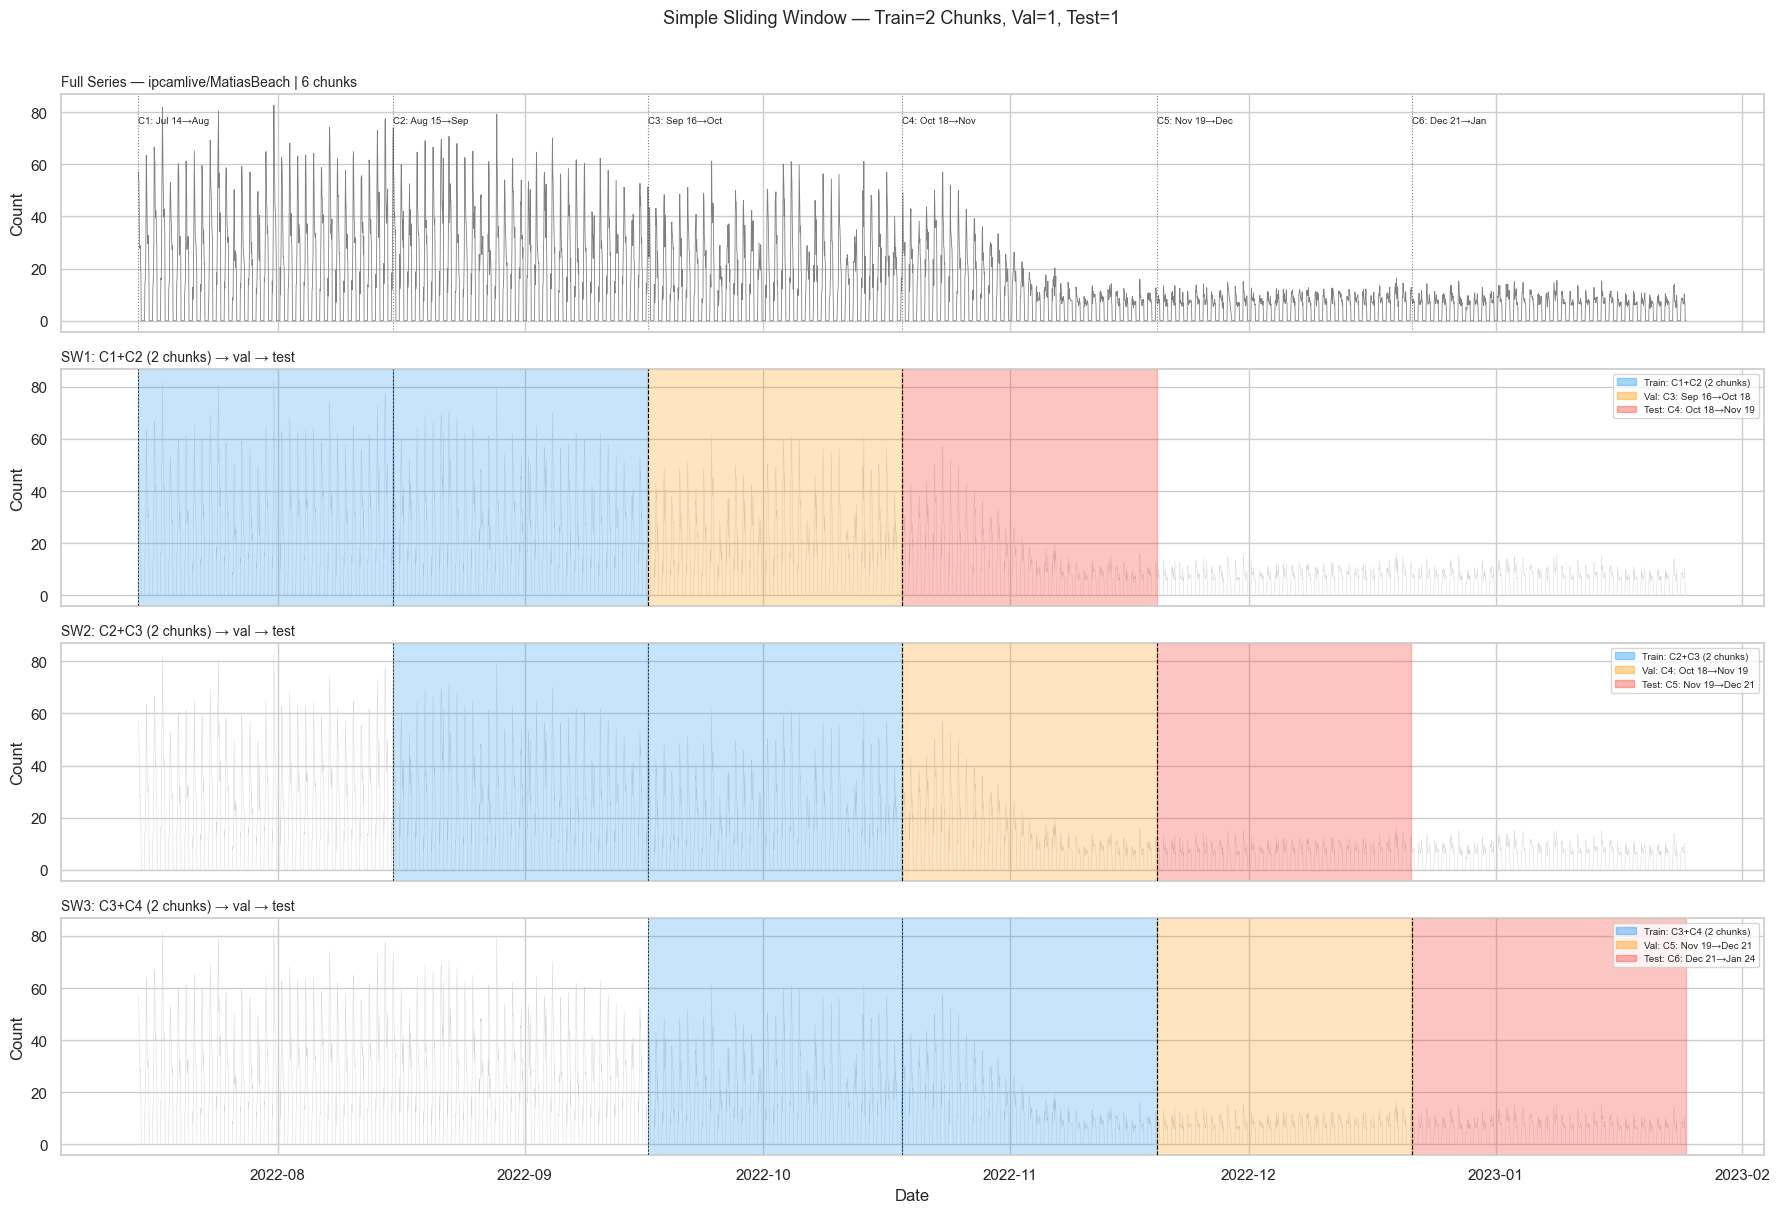

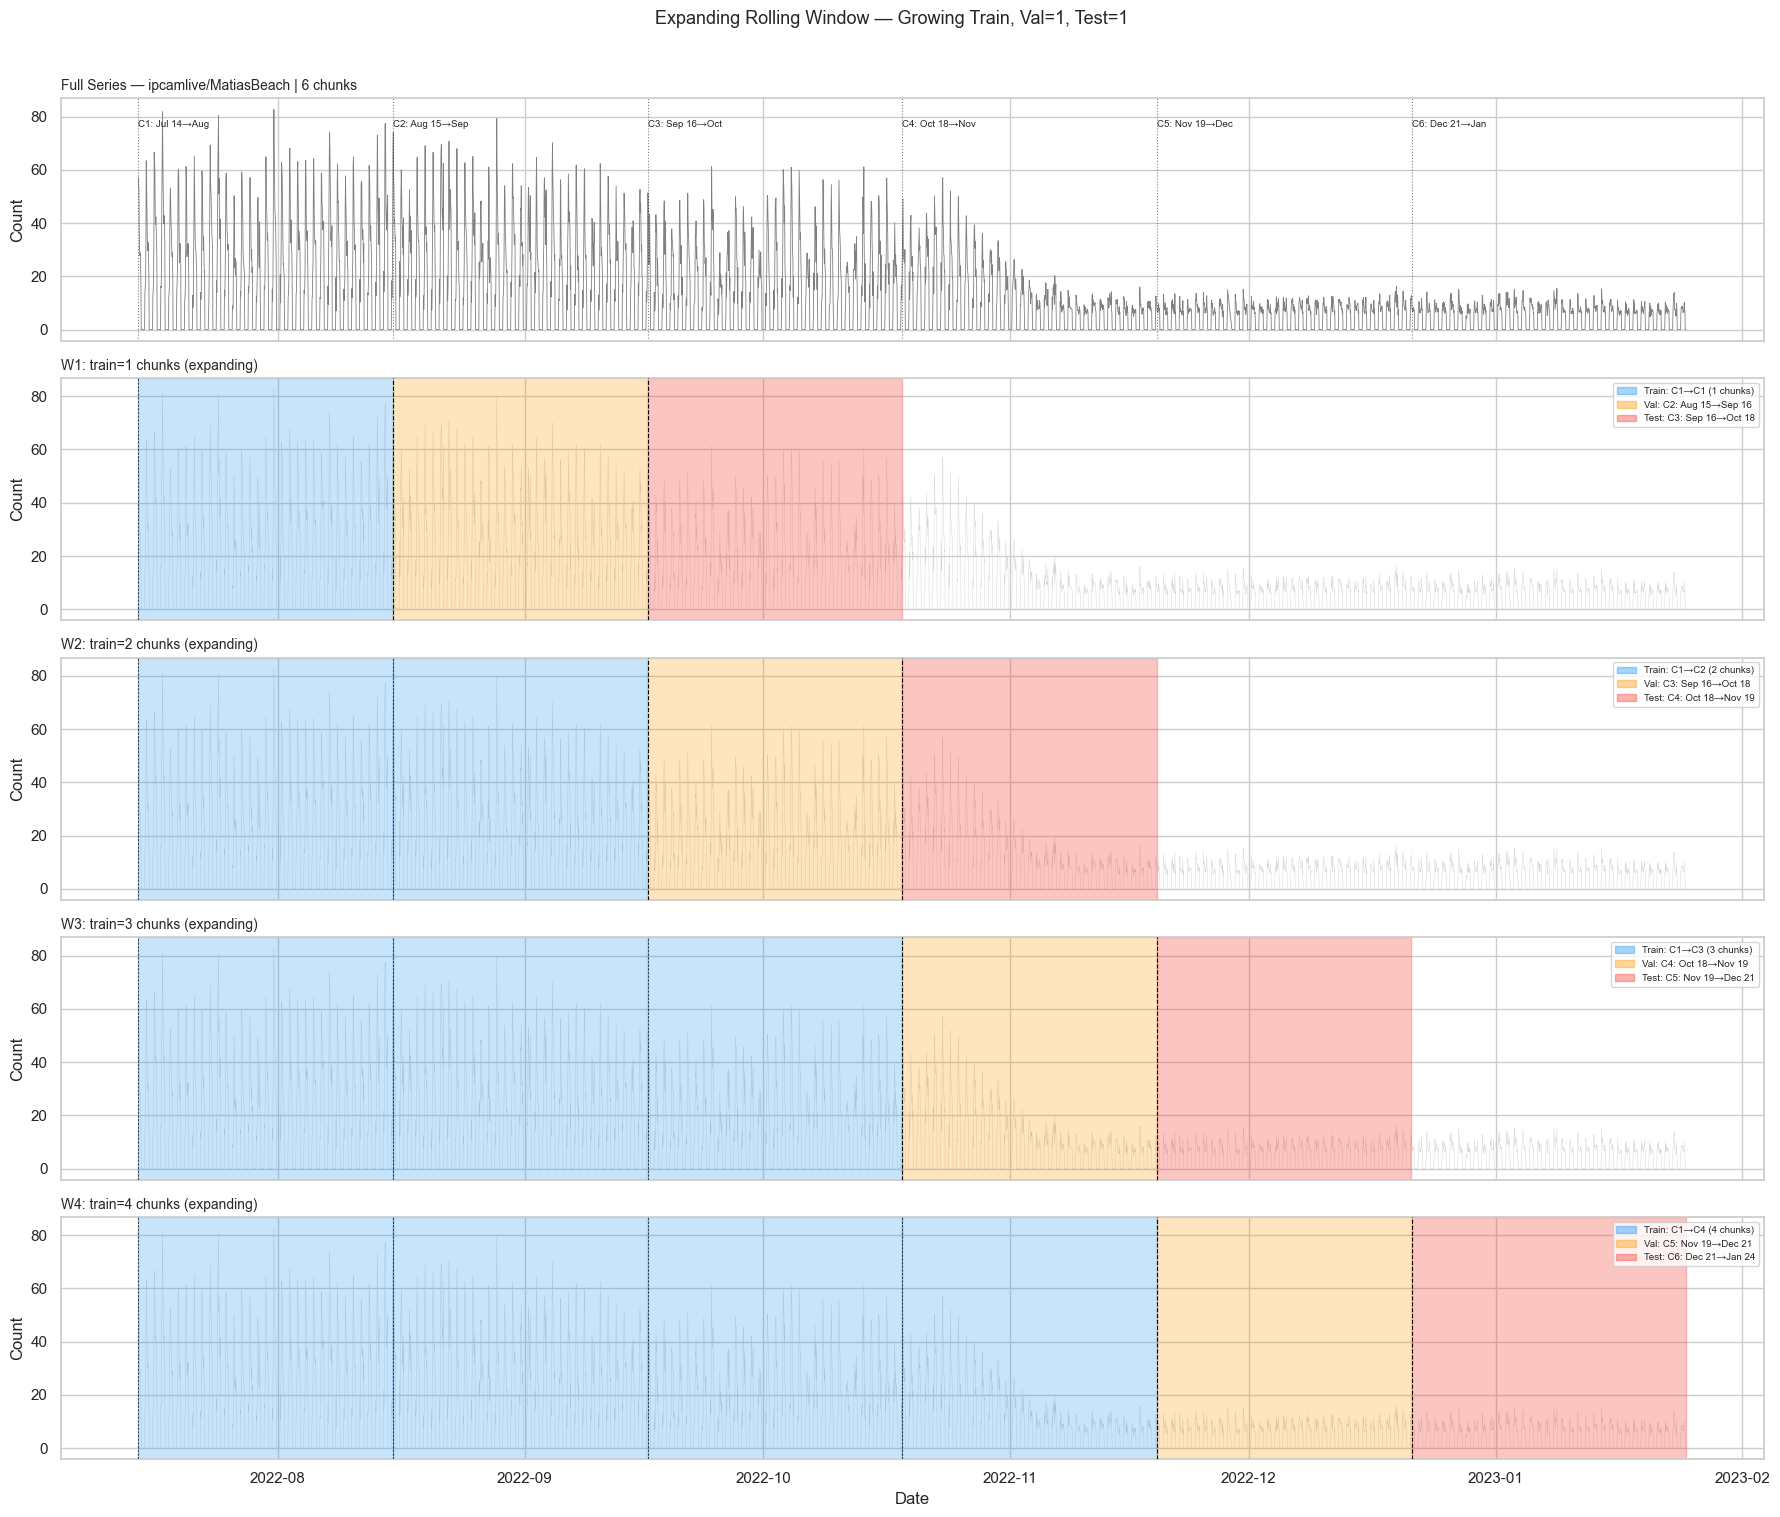

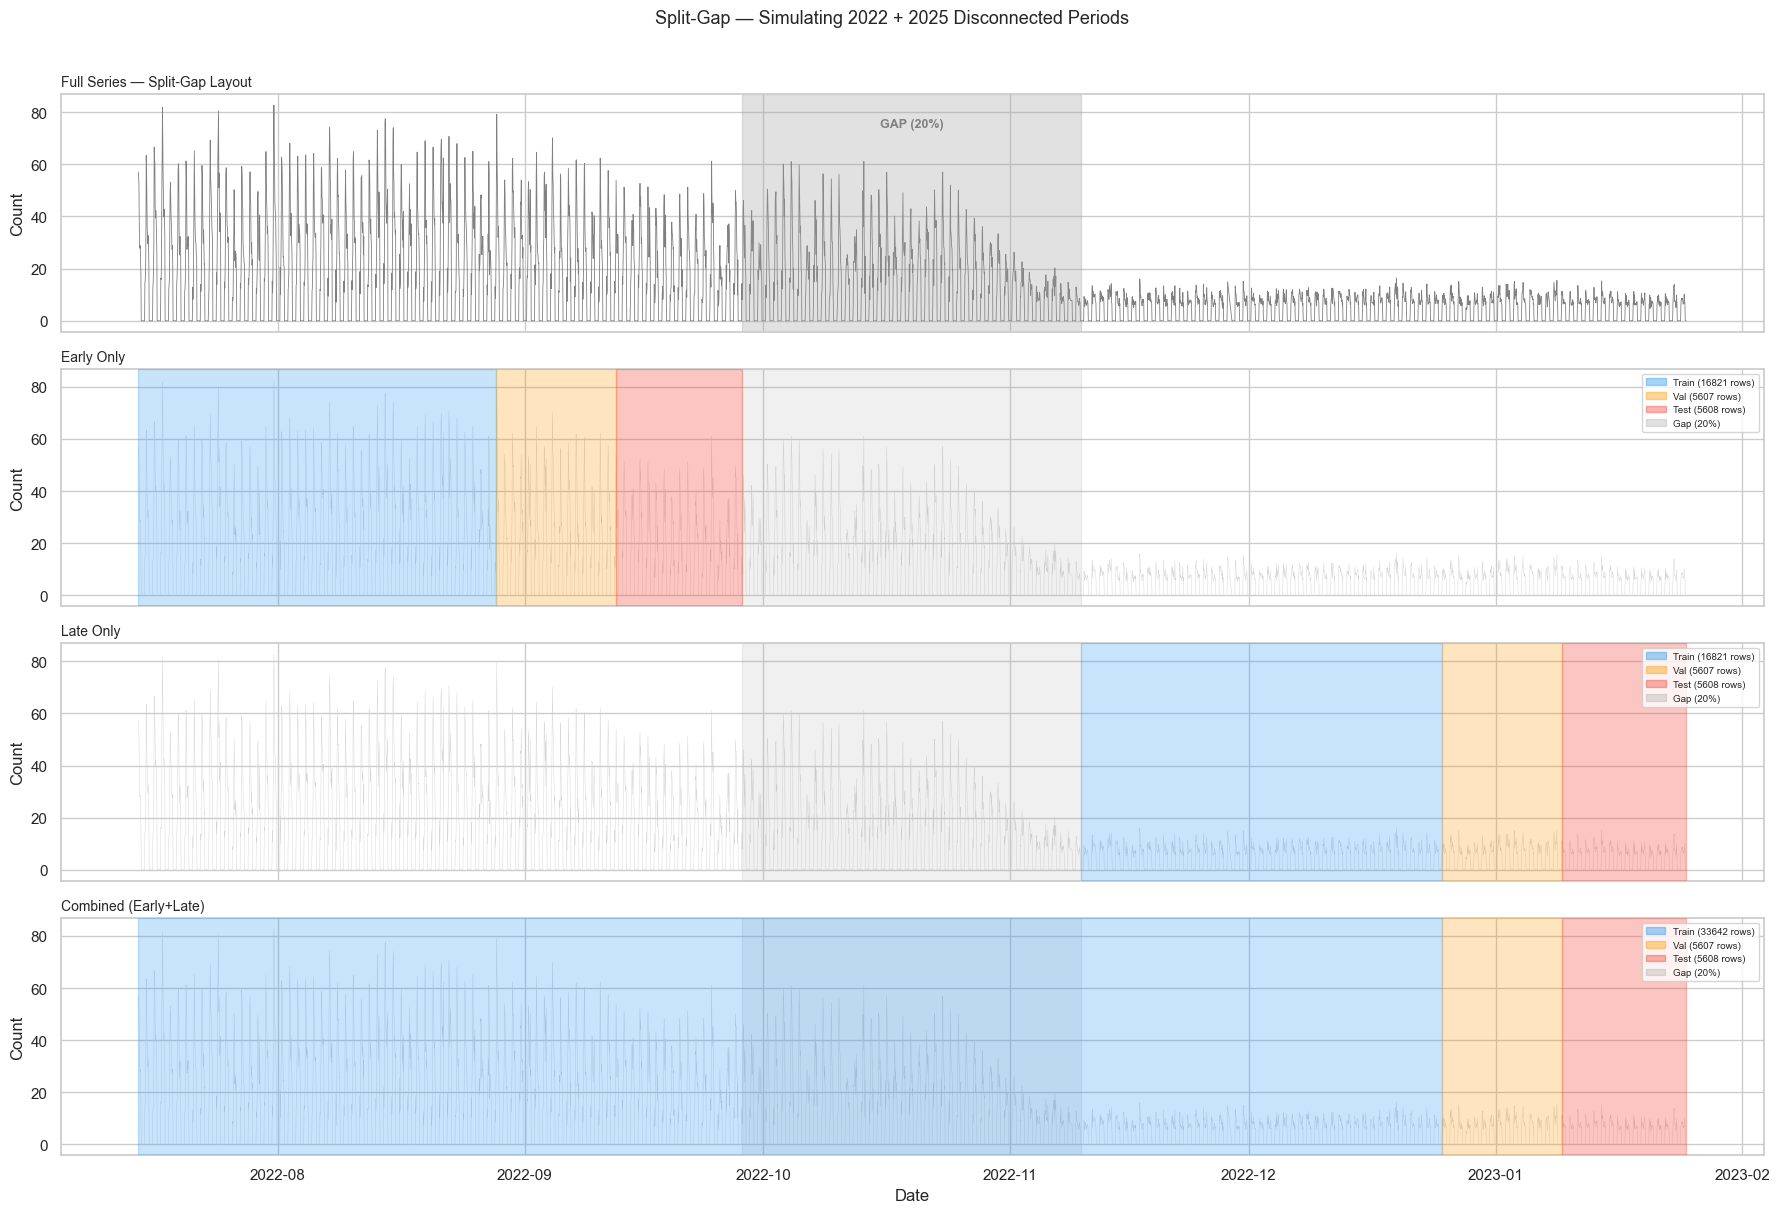

In [12]:
# === 1. SIMPLE SLIDING WINDOW (2 chunks train) ===
chunks = all_chunks['Night0']
simple_windows = simple_windows_all['Night0']
example_uid = df['beach_folder'].value_counts().idxmax()
ds_show = datasets['Night0']
example = ds_show[ds_show['beach_folder'] == example_uid].sort_values('datetime')

c_train = '#2196F3'
c_val = '#FF9800'
c_test = '#F44336'

fig, axes = plt.subplots(len(simple_windows) + 1, 1,
                         figsize=(18, 3 * (len(simple_windows) + 1)), sharex=True)

axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
for c in chunks:
    axes[0].axvline(c['start'], color='black', linestyle=':', linewidth=0.8, alpha=0.5)
    axes[0].text(c['start'], example['count'].max() * 0.95, c['label'][:15], fontsize=7, va='top')
axes[0].set_title(f'Full Series — {example_uid[:40]} | {N_CHUNKS} chunks', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for w_idx, w in enumerate(simple_windows):
    ax = axes[w_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)

    for tc in w['train_chunks']:
        ax.axvspan(tc['start'], tc['end'], alpha=0.25, color=c_train, zorder=2)

    val_chunk = chunks[w_idx + 2]
    test_chunk = chunks[w_idx + 3]
    ax.axvspan(val_chunk['start'], val_chunk['end'], alpha=0.25, color=c_val, zorder=2)
    ax.axvspan(test_chunk['start'], test_chunk['end'], alpha=0.3, color=c_test, zorder=2)

    for tc in w['train_chunks']:
        ax.axvline(tc['start'], color='black', linestyle='--', linewidth=0.5, zorder=3)
    ax.axvline(val_chunk['start'], color='black', linestyle='--', linewidth=0.8, zorder=3)
    ax.axvline(test_chunk['start'], color='black', linestyle='--', linewidth=0.8, zorder=3)

    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train: {w['train_label']}")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val: {w['val_label']}")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test: {w['test_label']}")
    ax.legend(handles=[t_patch, v_patch, te_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(f"{w['name']}: {w['train_label']} → val → test", fontsize=10, loc='left')

axes[-1].set_xlabel('Date')
plt.suptitle('Simple Sliding Window — Train=2 Chunks, Val=1, Test=1', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# === 2. EXPANDING ROLLING WINDOW ===
rw = rolling_windows['Night0']

fig, axes = plt.subplots(len(rw) + 1, 1, figsize=(18, 3 * (len(rw) + 1)), sharex=True)

axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
for c in chunks:
    axes[0].axvline(c['start'], color='black', linestyle=':', linewidth=0.8, alpha=0.5)
    axes[0].text(c['start'], example['count'].max() * 0.95, c['label'][:15], fontsize=7, va='top')
axes[0].set_title(f'Full Series — {example_uid[:40]} | {N_CHUNKS} chunks', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

for w_idx, w in enumerate(rw):
    ax = axes[w_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)

    for tc in w['train_chunks']:
        ax.axvspan(tc['start'], tc['end'], alpha=0.25, color=c_train, zorder=2)

    val_chunk = chunks[[i for i, c in enumerate(chunks) if c['label'] == w['val_label']][0]]
    test_chunk = chunks[[i for i, c in enumerate(chunks) if c['label'] == w['test_label']][0]]
    ax.axvspan(val_chunk['start'], val_chunk['end'], alpha=0.25, color=c_val, zorder=2)
    ax.axvspan(test_chunk['start'], test_chunk['end'], alpha=0.3, color=c_test, zorder=2)

    for tc in w['train_chunks']:
        ax.axvline(tc['start'], color='black', linestyle='--', linewidth=0.5, zorder=3)
    ax.axvline(val_chunk['start'], color='black', linestyle='--', linewidth=0.8, zorder=3)
    ax.axvline(test_chunk['start'], color='black', linestyle='--', linewidth=0.8, zorder=3)

    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train: {w['train_label']}")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val: {w['val_label']}")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test: {w['test_label']}")
    ax.legend(handles=[t_patch, v_patch, te_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(f"{w['name']}: train={len(w['train_chunks'])} chunks (expanding)", fontsize=10, loc='left')

axes[-1].set_xlabel('Date')
plt.suptitle('Expanding Rolling Window — Growing Train, Val=1, Test=1', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# === 3. SPLIT-GAP VISUALIZATION ===
sg = split_gap_windows['Night0']
c_gap = '#9E9E9E'

fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

axes[0].plot(example['datetime'], example['count'], linewidth=0.6, color='gray')
axes[0].axvspan(sg['gap_start'], sg['gap_end'], alpha=0.3, color=c_gap, zorder=2)
axes[0].text(sg['gap_start'] + (sg['gap_end'] - sg['gap_start'])/2, example['count'].max() * 0.9,
            'GAP (20%)', ha='center', fontsize=9, fontweight='bold', color='gray')
axes[0].set_title('Full Series — Split-Gap Layout', fontsize=10, loc='left')
axes[0].set_ylabel('Count')

labels = ['Early Only', 'Late Only', 'Combined (Early+Late)']
exp_keys = ['early', 'late', 'combined']

for ax_idx, (label, key) in enumerate(zip(labels, exp_keys)):
    ax = axes[ax_idx + 1]
    ax.plot(example['datetime'], example['count'], linewidth=0.3, color='lightgray', zorder=1)
    ax.axvspan(sg['gap_start'], sg['gap_end'], alpha=0.15, color=c_gap, zorder=2)

    exp = sg[key]
    tr, va, te = exp['train_data'], exp['val_data'], exp['test_data']

    ax.axvspan(tr['datetime'].min(), tr['datetime'].max(), alpha=0.25, color=c_train, zorder=3)
    ax.axvspan(va['datetime'].min(), va['datetime'].max(), alpha=0.25, color=c_val, zorder=3)
    ax.axvspan(te['datetime'].min(), te['datetime'].max(), alpha=0.3, color=c_test, zorder=3)

    t_patch = mpatches.Patch(color=c_train, alpha=0.4, label=f"Train ({len(tr)} rows)")
    v_patch = mpatches.Patch(color=c_val, alpha=0.4, label=f"Val ({len(va)} rows)")
    te_patch = mpatches.Patch(color=c_test, alpha=0.4, label=f"Test ({len(te)} rows)")
    g_patch = mpatches.Patch(color=c_gap, alpha=0.3, label='Gap (20%)')
    ax.legend(handles=[t_patch, v_patch, te_patch, g_patch], loc='upper right', fontsize=7)
    ax.set_ylabel('Count')
    ax.set_title(f'{label}', fontsize=10, loc='left')

axes[-1].set_xlabel('Date')
plt.suptitle('Split-Gap — Simulating 2022 + 2025 Disconnected Periods', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## TFT — Sliding Window Experiments

For each dataset strategy, train TFT on chunk *i*, validate on chunk *i+1*, test on chunk *i+2*.

In [ ]:
all_results = []
all_cv_details = []

def run_tft_experiment(exp_name, exp_type, ds_name, train_data, val_data, test_data,
                       train_label, val_label, test_label):
    nf_train = prepare_nf_data(train_data)
    nf_val = prepare_nf_data(val_data)
    nf_test = prepare_nf_data(test_data)

    common_ids = (set(nf_train['unique_id'].unique()) &
                  set(nf_val['unique_id'].unique()) &
                  set(nf_test['unique_id'].unique()))

    if len(common_ids) == 0:
        print(f"  {exp_name}: no common series, skipping")
        return

    nf_train = nf_train[nf_train['unique_id'].isin(common_ids)].reset_index(drop=True)
    nf_val = nf_val[nf_val['unique_id'].isin(common_ids)].reset_index(drop=True)
    nf_test = nf_test[nf_test['unique_id'].isin(common_ids)].reset_index(drop=True)

    nf_all = pd.concat([nf_train, nf_val, nf_test]).sort_values(['unique_id', 'ds']).reset_index(drop=True)
    nf_all = nf_all.drop_duplicates(subset=['unique_id', 'ds'], keep='last').reset_index(drop=True)

    test_horizon = nf_test.groupby('unique_id').size().min()
    horizon = min(HORIZON, test_horizon)

    print(f"\n  {exp_name} | h={horizon} | series={len(common_ids)}")
    print(f"    Train: {train_label} ({len(train_data)} rows)")
    print(f"    Val:   {val_label} | Test: {test_label}")

    try:
        t0 = time.time()
        model = TFT(
            h=horizon, input_size=INPUT_SIZE, hidden_size=64, n_head=4,
            max_steps=MAX_STEPS, early_stop_patience_steps=-1,
            learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,
            scaler_type='robust', random_seed=42,
            accelerator=ACCELERATOR, devices=DEVICES,
            loss=MAE(), hist_exog_list=ALL_FEATURES, val_check_steps=50,
        )

        nf = NeuralForecast(models=[model], freq='h')
        cv_results = nf.cross_validation(df=nf_all, n_windows=1, step_size=horizon)
        elapsed = time.time() - t0

        pred_col = [c for c in cv_results.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]
        y_true = cv_results['y'].values
        y_pred = np.clip(cv_results[pred_col].values, 0, None)
        m = calc_metrics(y_true, y_pred, y_true.max())

        beach_results = []
        for b in cv_results['unique_id'].unique():
            mask = cv_results['unique_id'] == b
            if mask.sum() < 3:
                continue
            yt = cv_results.loc[mask, 'y'].values
            yp = np.clip(cv_results.loc[mask, pred_col].values, 0, None)
            bm = calc_metrics(yt, yp, yt.max())
            bm['beach'] = b
            bm['max_count'] = yt.max()
            beach_results.append(bm)

        beach_df = pd.DataFrame(beach_results)
        avg_rel = beach_df['RelMAE'].mean() if len(beach_df) > 0 else np.nan

        all_results.append({
            'Model': 'TFT', 'Dataset': ds_name, 'Experiment': exp_type,
            'Window': exp_name, 'MAE': m['MAE'], 'RMSE': m['RMSE'], 'R2': m['R2'],
            'AvgRelMAE': avg_rel, 'Time': elapsed,
            'train_period': train_label, 'val_period': val_label, 'test_period': test_label,
            'train_rows': len(train_data),
        })
        all_cv_details.append({
            'ds_name': ds_name, 'exp_type': exp_type, 'window': exp_name,
            'merged': cv_results.rename(columns={pred_col: 'pred'}),
            'pred_col': 'pred', 'beach_df': beach_df,
        })
        print(f"    {elapsed:.0f}s | MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}% | R²={m['R2']:.3f}")

    except Exception as e:
        print(f"    ERROR: {e}")
        import traceback
        traceback.print_exc()

# ============================
# RUN ALL 3 EXPERIMENT TYPES
# ============================
for ds_name in ['Full24h', 'Night0', 'NightQ1', 'NightMin']:
    chunks = all_chunks[ds_name]

    # --- 1. SIMPLE SLIDING (2 chunks train, 1 val, 1 test) ---
    print(f"\n{'#' * 70}")
    print(f"# SIMPLE SLIDING — {ds_name}")
    print(f"{'#' * 70}")
    for w in simple_windows_all[ds_name]:
        run_tft_experiment(
            exp_name=w['name'], exp_type="Simple",
            ds_name=ds_name,
            train_data=w['train_data'],
            val_data=w['val_data'],
            test_data=w['test_data'],
            train_label=w['train_label'],
            val_label=w['val_label'],
            test_label=w['test_label'],
        )

    # --- 2. EXPANDING ROLLING (growing train) ---
    print(f"\n{'#' * 70}")
    print(f"# EXPANDING ROLLING — {ds_name}")
    print(f"{'#' * 70}")
    for w in rolling_windows[ds_name]:
        run_tft_experiment(
            exp_name=w['name'], exp_type="Expanding",
            ds_name=ds_name,
            train_data=w['train_data'],
            val_data=w['val_data'],
            test_data=w['test_data'],
            train_label=w['train_label'],
            val_label=w['val_label'],
            test_label=w['test_label'],
        )

    # --- 3. SPLIT-GAP (early only, late only, combined) ---
    print(f"\n{'#' * 70}")
    print(f"# SPLIT-GAP — {ds_name}")
    print(f"{'#' * 70}")
    sg = split_gap_windows[ds_name]
    for key, label in [('early', 'SG_Early'), ('late', 'SG_Late'), ('combined', 'SG_Combined')]:
        exp = sg[key]
        run_tft_experiment(
            exp_name=label, exp_type="SplitGap",
            ds_name=ds_name,
            train_data=exp['train_data'],
            val_data=exp['val_data'],
            test_data=exp['test_data'],
            train_label=exp['train_label'],
            val_label=exp['val_label'],
            test_label=exp['test_label'],
        )


######################################################################
# SIMPLE SLIDING — Full24h
######################################################################


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  SW1 | h=168 | val=503 | series=16
    Train: C1+C2 (2 chunks) (23832 rows)
    Val:   C3: Sep 16→Oct 18 | Test: C4: Oct 18→Nov 19



  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 4.7 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 977 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.187     Total estimated model params size (MB)
368       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …


Detected KeyboardInterrupt, attempting graceful shutdown ...


    ERROR: name 'exit' is not defined


Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/trainer.py", line 1012, in _run
    results = self._run_stage()
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/trainer.py", line 1056, in _run_stage
    self.fit_loop.run()
    ~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py", line 216, in run
    self.advance()
    ~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py", line 455, in advance
    self.epoch_loop.run(self._dat


  SW2 | h=168 | val=553 | series=16
    Train: C2+C3 (2 chunks) (22461 rows)
    Val:   C4: Oct 18→Nov 19 | Test: C5: Nov 19→Dec 21



  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 4.7 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 977 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.187     Total estimated model params size (MB)
368       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

## Results

In [ ]:
results_df = pd.DataFrame(all_results)

save_dir = Path(SAVE_DIR)
save_dir.mkdir(parents=True, exist_ok=True)
results_df.to_csv(save_dir / 'tft_chunk_results.csv', index=False)

print("=" * 70)
print("ALL RESULTS")
print("=" * 70)
print(results_df[['Dataset', 'Experiment', 'Window', 'train_rows', 'MAE', 'R2', 'AvgRelMAE', 'Time']].to_string(index=False))

In [ ]:
for exp_type in results_df['Experiment'].unique():
    sub = results_df[results_df['Experiment'] == exp_type]
    print(f"\n{'=' * 60}")
    print(f"{exp_type} — AvgRelMAE (%)")
    print(f"{'=' * 60}")
    pivot = sub.pivot_table(index='Dataset', columns='Window', values='AvgRelMAE')
    print(pivot.round(1).to_string())

    print(f"\n{exp_type} — R²")
    pivot_r2 = sub.pivot_table(index='Dataset', columns='Window', values='R2')
    print(pivot_r2.round(3).to_string())

### Experiment Comparison

In [ ]:
if len(results_df) > 0:
    exp_types = results_df['Experiment'].unique()
    n_exp = len(exp_types)
    
    fig, axes = plt.subplots(n_exp, 2, figsize=(16, 5 * n_exp))
    if n_exp == 1:
        axes = axes.reshape(1, -1)
    
    for row, exp_type in enumerate(exp_types):
        sub = results_df[results_df['Experiment'] == exp_type]
        
        pivot = sub.pivot_table(index='Dataset', columns='Window', values='AvgRelMAE')
        pivot.plot(kind='bar', ax=axes[row, 0], width=0.7, colormap='Set2')
        axes[row, 0].set_ylabel('AvgRelMAE (%)')
        axes[row, 0].set_title(f'{exp_type} — RelMAE (lower is better)')
        axes[row, 0].tick_params(axis='x', rotation=30)
        axes[row, 0].legend(title='Window', fontsize=7)
        
        pivot_r2 = sub.pivot_table(index='Dataset', columns='Window', values='R2')
        pivot_r2.plot(kind='bar', ax=axes[row, 1], width=0.7, colormap='Set2')
        axes[row, 1].set_ylabel('R²')
        axes[row, 1].set_title(f'{exp_type} — R² (higher is better)')
        axes[row, 1].tick_params(axis='x', rotation=30)
        axes[row, 1].legend(title='Window', fontsize=7)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_all_experiments.png', dpi=150)
    plt.show()

# Training size effect
ts_res = results_df[results_df['Experiment'] == 'TrainSize']
if len(ts_res) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for ds in ts_res['Dataset'].unique():
        sub = ts_res[ts_res['Dataset'] == ds].sort_values('train_rows')
        axes[0].plot(sub['train_rows'], sub['AvgRelMAE'], 'o-', label=ds, markersize=6)
        axes[1].plot(sub['train_rows'], sub['R2'], 'o-', label=ds, markersize=6)
    
    axes[0].set_xlabel('Training Rows')
    axes[0].set_ylabel('AvgRelMAE (%)')
    axes[0].set_title('Effect of Training Size on RelMAE')
    axes[0].legend()
    
    axes[1].set_xlabel('Training Rows')
    axes[1].set_ylabel('R²')
    axes[1].set_title('Effect of Training Size on R²')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_trainsize_effect.png', dpi=150)
    plt.show()

# Dataset ranking
if len(results_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    ranking = results_df.groupby(['Dataset', 'Experiment'])['AvgRelMAE'].mean().unstack()
    ranking = ranking.loc[ranking.mean(axis=1).sort_values().index]
    ranking.plot(kind='barh', ax=ax, width=0.7)
    ax.set_xlabel('Mean AvgRelMAE (%)')
    ax.set_title('Dataset Strategy Ranking by Experiment Type')
    ax.legend(title='Experiment')
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_dataset_ranking.png', dpi=150)
    plt.show()

### Predictions vs Actual — Best Window

In [ ]:
if len(all_cv_details) > 0:
    best_idx = results_df['AvgRelMAE'].idxmin()
    best_row = results_df.iloc[best_idx]
    best_detail = all_cv_details[best_idx]
    merged = best_detail['merged']
    pred_col = best_detail['pred_col']
    
    beaches = merged['unique_id'].unique()
    n_show = min(6, len(beaches))
    fig, axes = plt.subplots(n_show, 1, figsize=(16, 3 * n_show), sharex=False)
    if n_show == 1:
        axes = [axes]
    
    for ax, beach in zip(axes, beaches[:n_show]):
        sub = merged[merged['unique_id'] == beach].sort_values('ds')
        ax.plot(sub['ds'], sub['y'], label='Actual', color='steelblue', linewidth=1)
        ax.plot(sub['ds'], np.clip(sub[pred_col], 0, None), label='TFT', color='coral', linewidth=1, alpha=0.8)
        ax.fill_between(sub['ds'], sub['y'], np.clip(sub[pred_col], 0, None), alpha=0.15, color='red')
        
        mae = mean_absolute_error(sub['y'], np.clip(sub[pred_col], 0, None))
        r2 = r2_score(sub['y'], np.clip(sub[pred_col], 0, None)) if len(sub) > 1 else 0
        ax.set_title(f'{beach[:35]} | MAE={mae:.1f} | R²={r2:.3f}', fontsize=9, loc='left')
        ax.legend(loc='upper right', fontsize=8)
        ax.set_ylabel('Count')
    
    axes[-1].set_xlabel('Date')
    plt.suptitle(f"Best: {best_row['Dataset']} {best_row['Window']} | RelMAE={best_row['AvgRelMAE']:.1f}%", fontsize=13, y=1.01)
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_predictions_best.png', dpi=150)
    plt.show()

### Error Analysis

In [ ]:
if len(all_cv_details) > 0:
    best_idx = results_df['AvgRelMAE'].idxmin()
    best_detail = all_cv_details[best_idx]
    merged = best_detail['merged']
    pred_col = best_detail['pred_col']
    
    errors = merged['y'].values - np.clip(merged[pred_col].values, 0, None)
    abs_errors = np.abs(errors)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0,0].hist(errors, bins=80, color='steelblue', alpha=0.7, edgecolor='white')
    axes[0,0].axvline(0, color='red', linestyle='--')
    axes[0,0].axvline(errors.mean(), color='orange', linestyle='--', label=f'Bias={errors.mean():.1f}')
    axes[0,0].set_xlabel('Error')
    axes[0,0].set_title('Error Distribution')
    axes[0,0].legend()
    
    axes[0,1].scatter(merged['y'], np.clip(merged[pred_col], 0, None), s=2, alpha=0.3, color='steelblue')
    mx = max(merged['y'].max(), merged[pred_col].max())
    axes[0,1].plot([0, mx], [0, mx], 'r--', linewidth=1)
    axes[0,1].set_xlabel('Actual')
    axes[0,1].set_ylabel('Predicted')
    axes[0,1].set_title('Actual vs Predicted')
    
    merged_t = merged.copy()
    merged_t['hour'] = merged_t['ds'].dt.hour
    merged_t['abs_err'] = abs_errors
    hourly = merged_t.groupby('hour')['abs_err'].mean()
    axes[1,0].bar(hourly.index, hourly.values, color='coral', alpha=0.7)
    axes[1,0].set_xlabel('Hour')
    axes[1,0].set_ylabel('MAE')
    axes[1,0].set_title('Error by Hour')
    
    bdf = best_detail['beach_df'].sort_values('RelMAE')
    colors = ['green' if v < 30 else 'steelblue' if v < 60 else 'coral' for v in bdf['RelMAE']]
    axes[1,1].barh(range(len(bdf)), bdf['RelMAE'], color=colors, alpha=0.8)
    axes[1,1].set_yticks(range(len(bdf)))
    axes[1,1].set_yticklabels([b[:30] for b in bdf['beach']], fontsize=6)
    axes[1,1].set_xlabel('RelMAE (%)')
    axes[1,1].set_title('Per-Beach RelMAE')
    axes[1,1].invert_yaxis()
    
    plt.suptitle('Error Analysis — Best Window', fontsize=13, y=1.01)
    plt.tight_layout()
    plt.savefig(save_dir / 'tft_error_analysis.png', dpi=150)
    plt.show()
    
    print(f"Bias: {errors.mean():.1f} | MAE: {abs_errors.mean():.1f} | Median AE: {np.median(abs_errors):.1f}")
    print(f"90th pct error: {np.percentile(abs_errors, 90):.1f}")

### Summary

In [ ]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print("\n--- Best per Experiment Type ---")
for exp_type in results_df['Experiment'].unique():
    sub = results_df[results_df['Experiment'] == exp_type]
    best = sub.loc[sub['AvgRelMAE'].idxmin()]
    print(f"  {exp_type:12s} | {best['Dataset']:10s} | {best['Window']} "
          f"| RelMAE={best['AvgRelMAE']:.1f}% | R²={best['R2']:.3f}")

print("\n--- Best per Dataset (across all experiments) ---")
for ds in results_df['Dataset'].unique():
    sub = results_df[results_df['Dataset'] == ds]
    best = sub.loc[sub['AvgRelMAE'].idxmin()]
    print(f"  {ds:10s} | {best['Experiment']:12s} {best['Window']} "
          f"| RelMAE={best['AvgRelMAE']:.1f}% | R²={best['R2']:.3f}")

print("\n--- Stability (CV% = std/mean across windows) ---")
for exp_type in results_df['Experiment'].unique():
    sub = results_df[results_df['Experiment'] == exp_type]
    stab = sub.groupby('Dataset')['AvgRelMAE'].agg(['mean', 'std'])
    stab['cv%'] = (stab['std'] / stab['mean'] * 100).round(1)
    print(f"\n  {exp_type}:")
    print(stab.sort_values('mean').round(1).to_string())

print("\n--- Training Size Effect (same test period) ---")
ts_res = results_df[results_df['Experiment'] == 'TrainSize']
if len(ts_res) > 0:
    for ds in ts_res['Dataset'].unique():
        sub = ts_res[ts_res['Dataset'] == ds].sort_values('train_rows')
        print(f"\n  {ds}:")
        for _, row in sub.iterrows():
            print(f"    {row['Window']:8s} ({row['train_rows']:5.0f} rows) | RelMAE={row['AvgRelMAE']:.1f}% | R²={row['R2']:.3f}")

overall = results_df.loc[results_df['AvgRelMAE'].idxmin()]
print(f"\n{'=' * 70}")
print(f"OVERALL BEST: {overall['Experiment']} | {overall['Dataset']} | {overall['Window']}")
print(f"  Train: {overall['train_period']}")
print(f"  Test:  {overall['test_period']}")
print(f"  RelMAE={overall['AvgRelMAE']:.1f}% | R²={overall['R2']:.3f} | MAE={overall['MAE']:.1f}")
print(f"{'=' * 70}")